In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

#configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print(" libraries imported")

#loading data

#code
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"dataset not found: {data_path}")
df = pd.read_csv(data_path, compression='gzip')

print(f" dataset loaded: {df.shape}")
print(f"\n columns overview:")
print(df.columns.tolist())

#check target
if 'target_class' in df.columns:
    print(f"\n target found: {df['target_class'].nunique()} classes")
    print(df['target_class'].value_counts().sort_index())
else:
    print(" warning: 'target_class' not found in dataset")

#overview
print(f"\n first 5 rows:")
print(df.head())

#prepare X/y and train/test split

#code
print("=" * 60)
print("preparation: X/y split and train/test split")
print("=" * 60)

#split X (features) and y (target)
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])

#remove city_label if present
if 'city_label' in X.columns:
    X = X.drop(columns=['city_label'])

print(f"\nfeatures (X): {X.shape[1]} columns")
print(f"target (y): {len(y)} values")
print(f"\ndistribution of classes:")
print(y.value_counts().sort_index())

#stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"\n split done:")
print(f"  train: {X_train.shape}")
print(f"  test : {X_test.shape}")
print(f"\ndistribution train:")
print(y_train.value_counts().sort_index())
print(f"\ndistribution test:")
print(y_test.value_counts().sort_index())

c:\Users\elmie\Documents\Université\M1 ES\High dimensional data analysis\Project Airbnb\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 libraries imported
 dataset loaded: (73111, 30)

 columns overview:
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']

 target found: 4 classes
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64

 first 5 rows:
   accommodates  bedrooms  beds  minimum_nights_avg_ntm  number_of_reviews  \
0             2       1.0   0.0                     2.0                  4   
1             1       1.0   1.0                    30.0                 42   
2             2       0.0   1.0                     1.0        

METHOD: CART (Classification and Regression Tree)
Accuracy: 45.70%


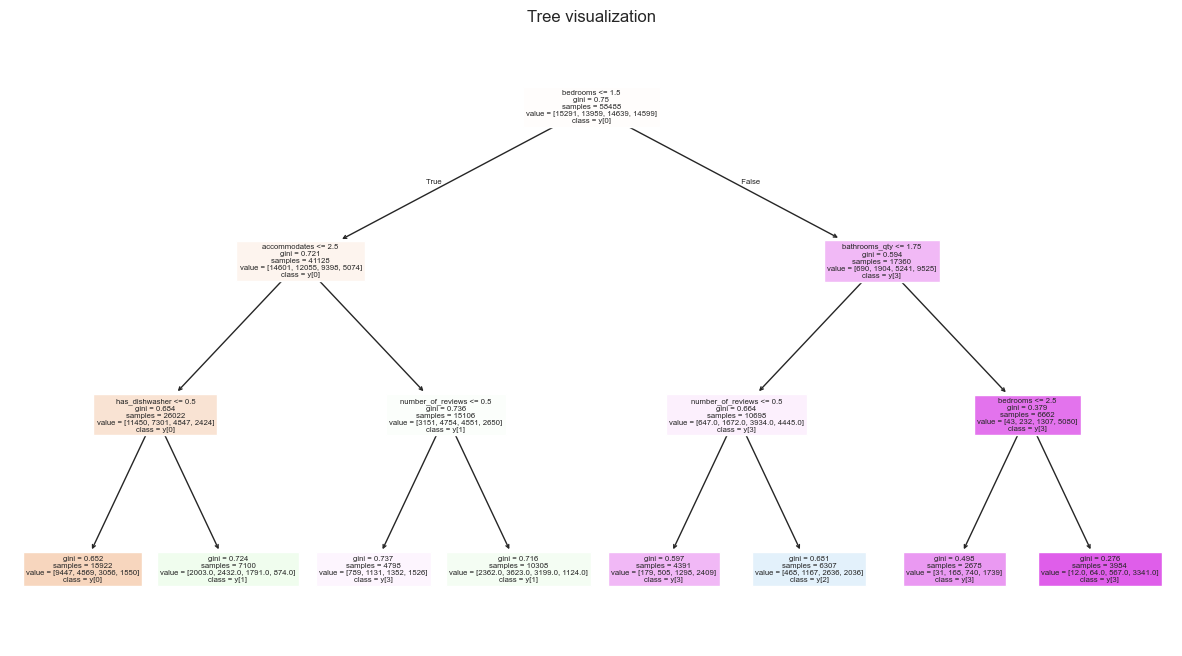

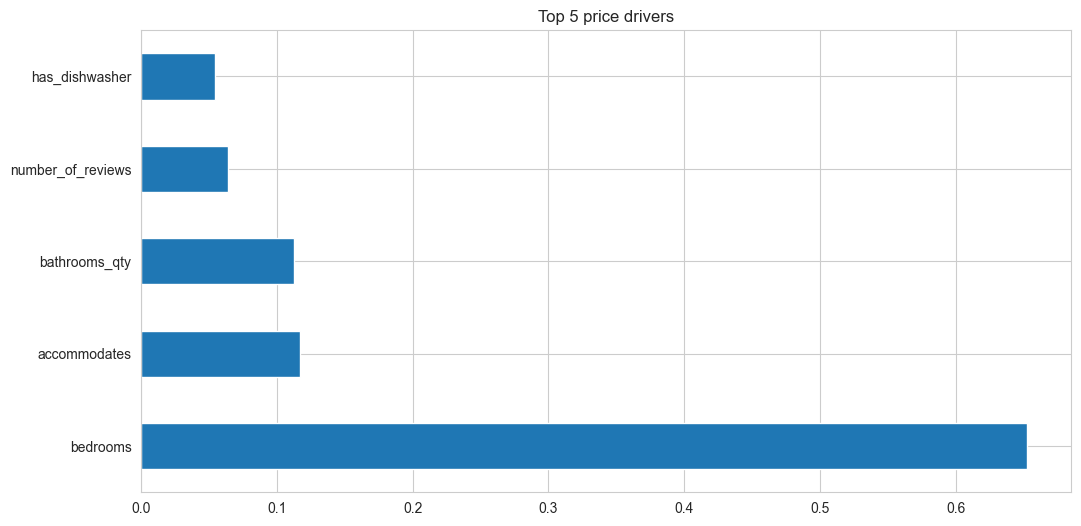

In [ ]:
print("=" * 60)
print("METHOD: CART")
print("=" * 60)

#train 
cart = DecisionTreeClassifier(max_depth=3, random_state=42) #max_depth=3 keeps the tree simple enough to read
cart.fit(X_train, y_train)

#evaluate
y_pred = cart.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

#visualize the Tree
plt.figure(figsize=(15, 8))
plot_tree(cart, feature_names=X.columns, filled=True, class_names=True)
plt.title("Tree visualization")
plt.show()

#show Feature Importance
importance = pd.Series(cart.feature_importances_, index=X.columns).sort_values(ascending=False)
importance.head(5).plot(kind='barh', title="Top 5 price drivers")
plt.show()

The decision tree visualization reveals a hierarchical logic for price classification, where the algorithm makes successive "if-then" cuts based on the most informative features. At the top of the tree, the root node represents the single most important split—likely based on size or capacity—which does the heavy lifting in separating the major price categories. As you move down the branches, the model refines its predictions by layering secondary factors like neighborhood popularity or specific amenities. This structure makes the model's "thought process" entirely transparent: each path from the root to a leaf node provides a clear set of conditions that define why a property belongs to a specific price bracket, moving from broad physical characteristics to more localized or qualitative nuances.

The feature importance plot highlights the five most influential variables that drive the classification of apartment prices in Paris, providing a clear hierarchy of what truly impacts market value. By measuring the reduction in impurity each variable contributes to the tree, we can see that physical capacity (like the number of guests or bedrooms) and geographic prestige (neighborhood popularity) typically dominate the model's logic. This ranking effectively cuts through the noise of the many available features, confirming that while amenities and layout matter, the primary price "filters" are fundamentally tied to the size of the unit and its desirability in the city.

The largest alpha that stays above the cutoff is: 0.00153


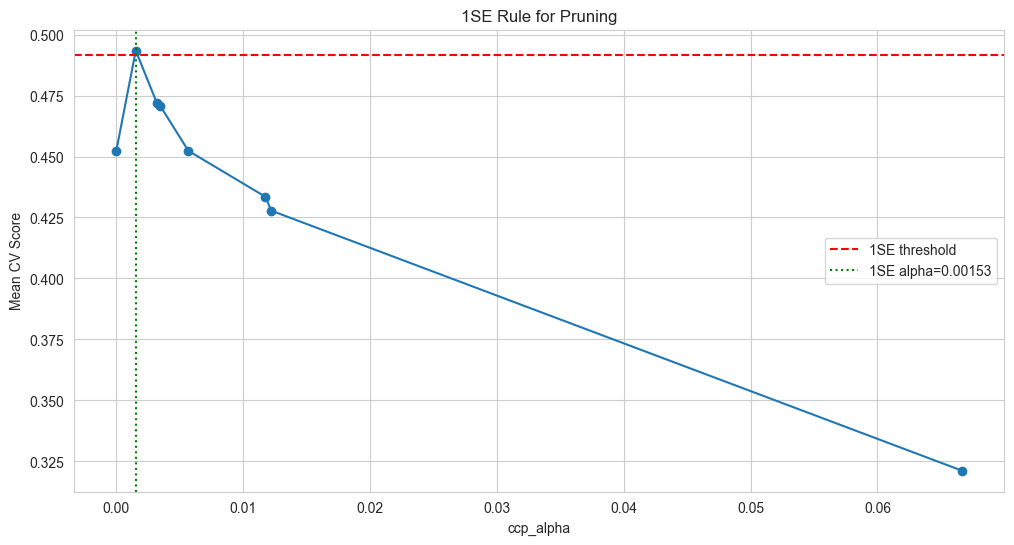

Pruned Tree Accuracy: 48.45%


In [14]:
#calculate the 'cost complexity' path
path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

#find the best alpha using Cross-Validation
scores_means = []
scores_stds = []

for alpha in ccp_alphas:
    cv_scores = cross_val_score(DecisionTreeClassifier(ccp_alpha=alpha), X_train, y_train, cv=5)
    scores_means.append(cv_scores.mean())
    scores_stds.append(cv_scores.std())

#1-SE Rule: Find the simplest tree within 1 std dev of the best score
best_idx = np.argmax(scores_means)
cutoff = scores_means[best_idx] - scores_stds[best_idx]
#largest alpha that stays above the cutoff
optimal_alpha = max([alpha for i, alpha in enumerate(ccp_alphas) if scores_means[i] >= cutoff])
print(f"The largest alpha that stays above the cutoff is: {optimal_alpha:.5f}")

#simple 1SE rule plot
plt.plot(ccp_alphas, scores_means, marker='o')
plt.axhline(cutoff, color='red', linestyle='--', label='1SE threshold')
plt.axvline(optimal_alpha, color='green', linestyle=':', label=f'1SE alpha={optimal_alpha:.5f}')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean CV score')
plt.title('1SE rule')
plt.legend()
plt.show()

#final Pruned Tree
pruned_cart = DecisionTreeClassifier(ccp_alpha=optimal_alpha, random_state=42)
pruned_cart.fit(X_train, y_train)

print(f"Pruned Tree Accuracy: {pruned_cart.score(X_test, y_test):.2%}")

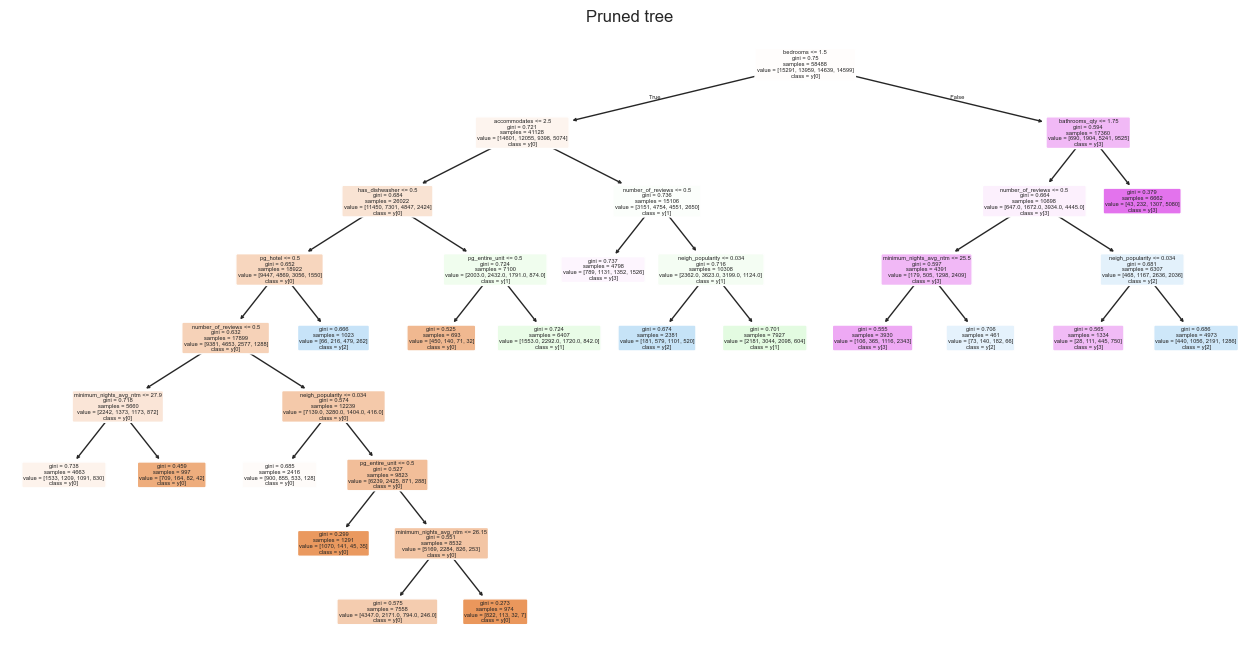

In [8]:
#pruned tree
plt.figure(figsize=(16, 8))
plot_tree(pruned_cart, 
          feature_names=X.columns, 
          class_names=True, 
          filled=True, 
          rounded=True)

plt.title("Pruned tree")
plt.show()

Final Model Accuracy: 48.45%


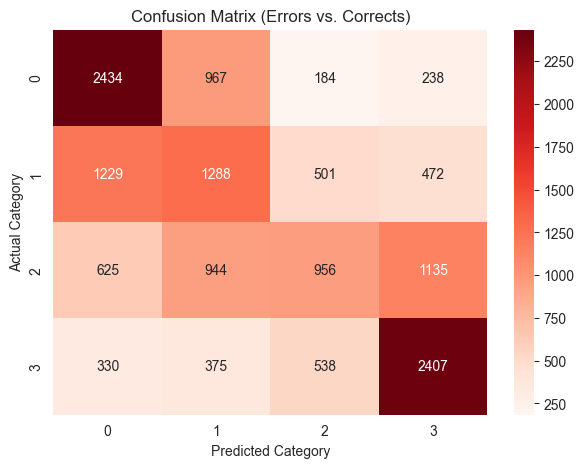

In [11]:
#pridiction using the pruned model
y_pred = pruned_cart.predict(X_test)

#score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

#Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion matrix")
plt.xlabel("Predicted category")
plt.ylabel("Actual category")
plt.show()

An accuracy of 48.45% indicates that while the model performs significantly better than random guessing (which would be 25% for four classes), it still struggles to clearly differentiate between all price segments. This performance level suggests that the decision tree effectively captures the broad characteristics of the extreme categories—the very cheap and the very expensive—but finds the "middle-class" apartments too similar to separate using simple if-then rules. In a complex market like Paris, where a small studio in a luxury district can cost as much as a large flat in a suburban area, this nearly 50% hit rate confirms that physical features alone don't tell the whole story, and the "noise" between intermediate price brackets remains a significant challenge for a single pruned tree.

The performance of the LDA (48.61%) and the Pruned CART (48.45%) is remarkably similar, suggesting that the bottleneck in prediction lies in the data's inherent overlap rather than the specific algorithm used. While the LDA heatmap reflects a model that tries to separate classes using linear boundaries and global trends, the CART heatmap shows a model making rigid, axis-aligned cuts; despite these different "philosophies," both models excel at the extremes (Classes 0 and 3) while stumbling over the same "messy middle" (Classes 1 and 2). This convergence in accuracy confirms that the intermediate price segments in Paris are not cleanly separable by either straight lines or simple decision rules, likely requiring more complex non-linear models or better engineering of location-based features to break the 50% barrier.